# Two component dark matter priors

In [1]:
import numpy as np, time, random

print(time.strftime("%H:%M:%S"))
random.seed(24)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
14:33:11


In [2]:
from gammabayes.likelihoods.irfs import IRF_LogLikelihood
from gammabayes.priors import DiscreteLogPrior, TwoCompPrior
from gammabayes.utils.config_utils import (
    read_config_file, 
    create_true_axes_from_config, 
    create_recon_axes_from_config, 
)
from gammabayes import ParameterSet
from matplotlib import pyplot as plt

config_file_path = 'HyperParameterInference_config.yaml'
config_dict = read_config_file(config_file_path)

parameter_sets              = [ParameterSet({param_spec[0]: param_spec[1]}) for param_spec in config_dict['prior_parameter_specifications'].items()]
mixture_bounds              = [config_dict['mixture_fraction_specifications'][mixture]['bounds'] for mixture in config_dict['mixture_fraction_specifications']]

NumEvents                   = config_dict['Nevents']
g1_fraction             = config_dict['gauss1_fraction']
g2_fraction             = config_dict['gauss2_fraction']
g3_fraction             = config_dict['gauss3_fraction']

ng1 = int(round(g1_fraction*NumEvents))
ng2 = int(round((1-g1_fraction)*g2_fraction*NumEvents))
ng3 = int(round((1-g1_fraction)*(1-g2_fraction)*g3_fraction*NumEvents))
ng4 = int(round((1-g1_fraction)*(1-g2_fraction)*(1-g3_fraction)*NumEvents))

print(ng1+ng2+ng3+ng4)


file path: HyperParameterInference_config.yaml
1000


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
energy_true_axis,  longitudeaxistrue, latitudeaxistrue       = create_true_axes_from_config(config_dict)
energy_recon_axis, longitudeaxis,     latitudeaxis           = create_recon_axes_from_config(config_dict)


irf_loglike = IRF_LogLikelihood(axes   =   [energy_recon_axis,    longitudeaxis,     latitudeaxis], 
                                dependent_axes =   [energy_true_axis,     longitudeaxistrue, latitudeaxistrue],
                                prod_vers='5') # or '3b'/3/'3'

# log_psf_normalisations, log_edisp_normalisations = irf_loglike.create_log_norm_matrices()
# irf_norm_matrix = log_psf_normalisations + log_edisp_normalisations
irf_norm_matrix = np.zeros(shape=(energy_true_axis.size,  
                                  longitudeaxistrue.size, 
                                  latitudeaxistrue.size))

0.2 90.0 100 0.1 -3.0 3.0 -3.0 3.0
0.2 90.0 50 0.1 -3.0 3.0 -3.0 3.0

Path to irf fits file: /Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/../package_data/irf_fits_files/prod5/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz

Number of input dimensions 3


In [4]:
# np.save('irf_norm_matrix.npy', irf_norm_matrix)
# irf_norm_matrix = np.load('irf_norm_matrix.npy')
irf_norm_matrix.shape

(266, 61, 61)

In [5]:
def proposal_func(energy, longitude, latitude, spectral_parameters={}, spatial_parameters={}):
    return np.log(energy**(-1))

proposal_prior = DiscreteLogPrior(logfunction          =   proposal_func,
                                       name                 =   'Proposal',
                                       axes                 =   (energy_true_axis, 
                                                                 longitudeaxistrue, 
                                                                 latitudeaxistrue,), 
                                       axes_names           =    ['energy', 'lon', 'lat'], )

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')


In [6]:
from scipy.stats import norm, multivariate_normal
from gammabayes.utils import update_with_defaults
import copy

class pseudo_spectral_comp():
    def __init__(self, default_parameter_values = {'loc':1.0,'scale':1.0},):
        self.default_parameter_values = default_parameter_values


    def __call__(self, *args, **kwargs) -> np.ndarray | float:
        return self.logfunc(*args, **kwargs)

    def logfunc(self, energy, kwd_parameters={}):
        update_with_defaults(kwd_parameters, self.default_parameter_values)
        return -(energy-kwd_parameters['loc'])**2/(2*kwd_parameters['scale']**2) - 0.5*(np.log(2*np.pi)) - np.log(kwd_parameters['scale'])

    def mesh_efficient_logfunc(self, energy, kwd_parameters):

        parameter_meshes = np.meshgrid(energy, *kwd_parameters.values(), indexing='ij')

        logspectralvals = self(
            energy = parameter_meshes[0].flatten(), 
            kwd_parameters={param_key: parameter_meshes[1+idx].flatten() for idx, param_key in enumerate(kwd_parameters.keys())}
            ).reshape(parameter_meshes[0].shape)
        
        return logspectralvals
    

class pseudo_spatial_comp():
    def __init__(self, default_parameter_values = {'loc':1.0,'scale':1.0},):
        self.default_parameter_values = default_parameter_values


    def __call__(self, *args, **kwargs) -> np.ndarray | float:
        
        return self.logfunc(*args, **kwargs)

    def logfunc(self, longitude, latitude, kwd_parameters={}):
        update_with_defaults(kwd_parameters, self.default_parameter_values)
        return -( (longitude-kwd_parameters['loc'])**2 + latitude**2)/(2*kwd_parameters['scale']**2) - np.log(2*np.pi) - np.log(kwd_parameters['scale'])

    def mesh_efficient_logfunc(self, longitude, latitude, kwd_parameters):

        parameter_meshes = np.meshgrid(longitude, latitude, *kwd_parameters.values(), indexing='ij')

        logspectralvals = self(
            longitude = parameter_meshes[0].flatten(), 
            latitude = parameter_meshes[1].flatten(), 
            kwd_parameters={param_key: parameter_meshes[2+idx].flatten() for idx, param_key in enumerate(kwd_parameters.keys())}
            ).reshape(parameter_meshes[0].shape)
        
        return logspectralvals
    


defaults_default = {'loc': 1.0, 'scale':1.0}


gauss1_spec_defaults = copy.deepcopy(defaults_default)
for param, default in parameter_sets[0].spectral_defaults.items():
    gauss1_spec_defaults[param] = default


gauss1_spat_defaults = copy.deepcopy(defaults_default)
for param, default in parameter_sets[0].spatial_defaults.items():
    gauss1_spat_defaults[param] = default


gauss2_spec_defaults = copy.deepcopy(defaults_default)
for param, default in parameter_sets[1].spectral_defaults.items():
    gauss2_spec_defaults[param] = default


gauss2_spat_defaults = copy.deepcopy(defaults_default)
for param, default in parameter_sets[1].spatial_defaults.items():
    gauss2_spat_defaults[param] = default


print(gauss1_spec_defaults)
print(gauss1_spat_defaults)
print(gauss2_spec_defaults)
print(gauss2_spat_defaults)


Gauss1_prior = TwoCompPrior(
    spectral_class  = pseudo_spectral_comp, 
    spatial_class   = pseudo_spatial_comp,
    name = 'Gauss1_prior',
    irf_loglike=irf_loglike, 
    axes=(energy_true_axis, 
            longitudeaxistrue, 
            latitudeaxistrue,), 
    axes_names=['energy', 'lon', 'lat'],
    spectral_class_kwds = {'default_parameter_values':gauss1_spec_defaults},
    spatial_class_kwds = {'default_parameter_values':gauss1_spat_defaults}
)


Gauss2_prior = TwoCompPrior(
    spectral_class  = pseudo_spectral_comp, 
    spatial_class   = pseudo_spatial_comp,
    name = 'Gauss2_prior',
    irf_loglike=irf_loglike, 
    axes=(energy_true_axis, 
            longitudeaxistrue, 
            latitudeaxistrue,), 
    axes_names=['energy', 'lon', 'lat'],
    spectral_class_kwds = {'default_parameter_values':gauss2_spec_defaults},
    spatial_class_kwds = {'default_parameter_values':gauss2_spat_defaults}
)

Gauss3_prior = TwoCompPrior(
    spectral_class  = pseudo_spectral_comp, 
    spatial_class   = pseudo_spatial_comp,
    name = 'Gauss2_prior',
    irf_loglike=irf_loglike, 
    axes=(energy_true_axis, 
            longitudeaxistrue, 
            latitudeaxistrue,), 
    axes_names=['energy', 'lon', 'lat'],
    spectral_class_kwds = {'default_parameter_values':{'loc': 80, 'scale':10.0}},
    spatial_class_kwds = {'default_parameter_values':{'loc':-1., 'scale':1.0}}
)

Gauss4_prior = TwoCompPrior(
    spectral_class  = pseudo_spectral_comp, 
    spatial_class   = pseudo_spatial_comp,
    name = 'Gauss2_prior',
    irf_loglike=irf_loglike, 
    axes=(energy_true_axis, 
            longitudeaxistrue, 
            latitudeaxistrue,), 
    axes_names=['energy', 'lon', 'lat'],
    spectral_class_kwds = {'default_parameter_values':{'loc': 0.05, 'scale':0.01}},
    spatial_class_kwds = {'default_parameter_values':{'loc':0., 'scale':5.}}
)

{'loc': 1.0, 'scale': 1.0}
{'loc': 1.0, 'scale': 0.1}
{'loc': 10.0, 'scale': 1.0}
{'loc': 1.0, 'scale': 3.0}


# Simulations

In [7]:
Gauss1_prior_event_data  = Gauss1_prior.sample(ng1)
Gauss2_prior_event_data  = Gauss2_prior.sample(ng2)
Gauss3_prior_event_data  = Gauss3_prior.sample(ng3)
Gauss4_prior_event_data  = Gauss4_prior.sample(ng4)

['Gauss1_prior']
['Gauss2_prior']
['Gauss2_prior']
['Gauss2_prior']


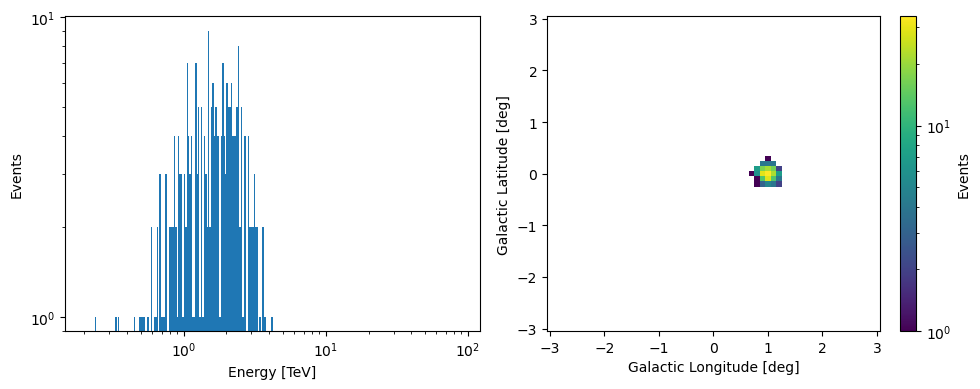

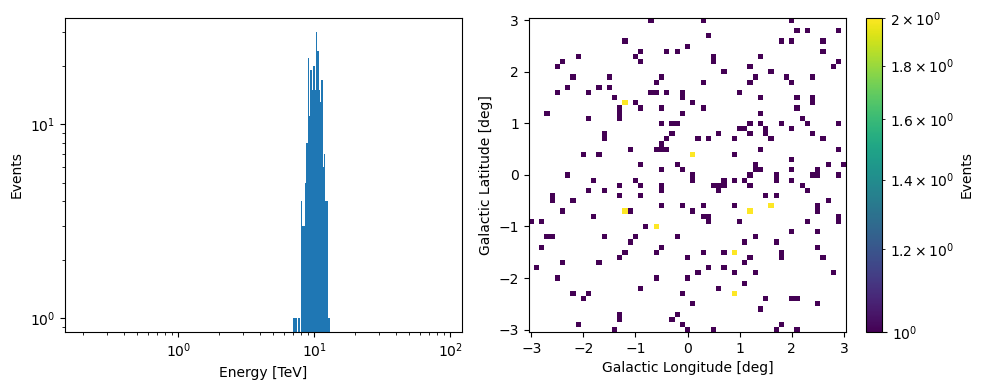

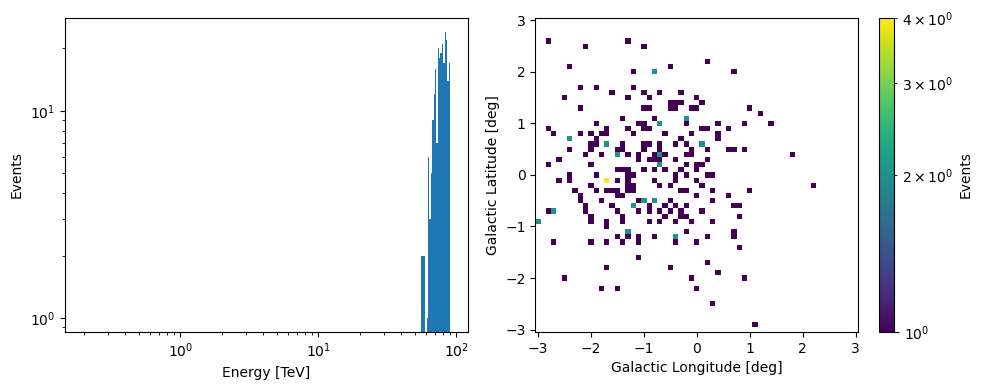

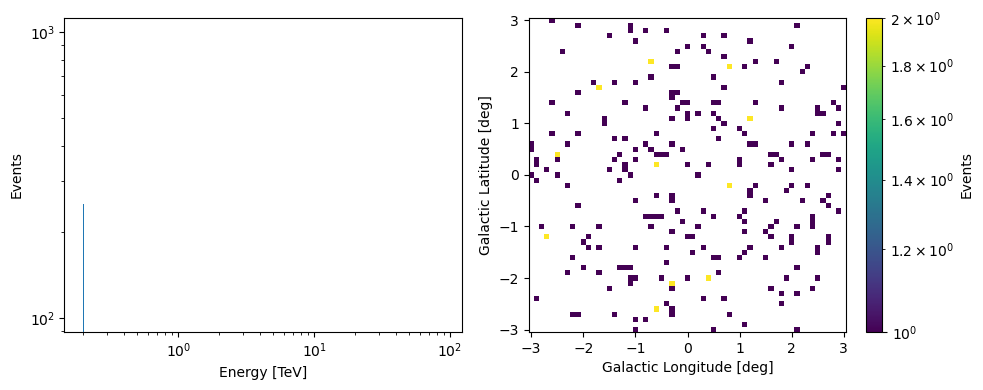

In [8]:
for source_idx, event_data in enumerate([Gauss1_prior_event_data, Gauss2_prior_event_data, Gauss3_prior_event_data, Gauss4_prior_event_data]):
    print(np.unique(event_data._source_ids))
    fig, ax = event_data.peek()


In [9]:
from gammabayes import EventData

true_events = Gauss1_prior_event_data + Gauss2_prior_event_data + Gauss3_prior_event_data + Gauss4_prior_event_data


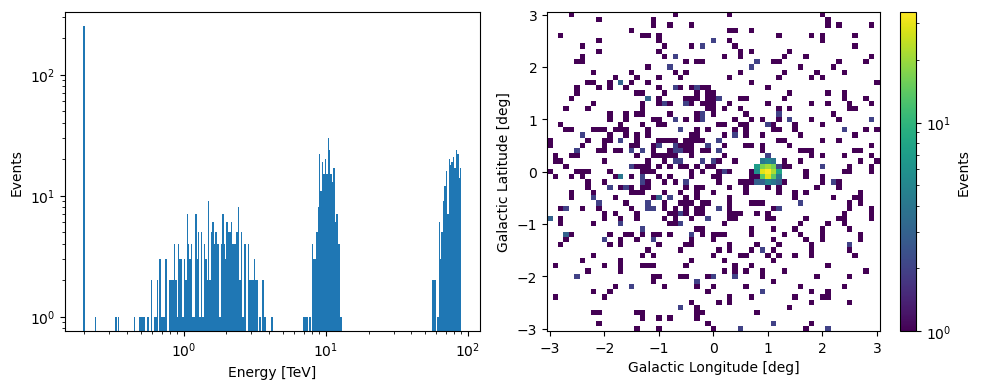

In [10]:
true_events.peek()
plt.show()

In [11]:
measured_event_data = irf_loglike.sample(true_events)

In [12]:
# measured_event_data.save("measured_data")

In [13]:
# measured_event_data.load("measured_data.h5")

# Nuisance Parameter Marg

In [14]:
from gammabayes.hyper_inference import DiscreteAdaptiveScan as discrete_scan_hyperparameter_likelihood
from gammabayes import ParameterSet

In [15]:
discrete_scan_hyperparameter_likelihood_instance = discrete_scan_hyperparameter_likelihood(
    log_priors=(Gauss1_prior, Gauss2_prior, Gauss3_prior, Gauss4_prior),
    log_likelihood=irf_loglike, 
    nuisance_axes = Gauss1_prior.axes, 
    axes=irf_loglike.axes,
    prior_parameter_specifications=parameter_sets, 
    log_likelihoodnormalisation=irf_norm_matrix,
    bounds=[['log10', 0.36], ['linear', 0.44], ['linear', 0.44]],
    mixture_fraction_exploration_type='sample')


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/hyper_inference/utils.py:50: UserWarning: 
You have specifed 2 less hyperparameter axes than priors. 
Assigning empty hyperparameter axes for remaining priors.
  warnings.warn(f"""


In [16]:
reshaped_log_marg_results = discrete_scan_hyperparameter_likelihood_instance.nuisance_log_marginalisation(
    measured_event_data=measured_event_data)

Setting up prior matrices: 100%|██████████| 4/4 [06:15<00:00, 93.84s/it] 


In [17]:
mixture_parameter_set = ParameterSet(config_dict['mixture_fraction_specifications'])

In [18]:
reshaped_log_marg_results[0].shape

(1000, 21, 34)

In [19]:
discrete_scan_hyperparameter_likelihood_instance.select_scan_output_exploration_class(
    log_nuisance_marg_results=reshaped_log_marg_results,
    mixture_parameter_specifications=mixture_parameter_set,
    prior_parameter_specifications = parameter_sets,
)

discrete_scan_hyperparameter_likelihood_instance.init_posterior_exploration()

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/hyper_inference/mixture_sampling_nuisance_scan_output.py:74: UserWarning: Number of mixtures +1 does not match number of 
priors indicated in log_nuisance_marg_results. Assigning min=0 and max=1 for remaining mixtures.
  warnings.warn("""Number of mixtures +1 does not match number of


In [20]:
discrete_scan_hyperparameter_likelihood_instance.run_posterior_exploration()

1787it [00:03, 198.15it/s, bound: 1 | nc: 1 | ncall: 17889 | eff(%):  9.989 | loglstar:   -inf < -7067.129 <    inf | logz: -7074.718 +/-  0.116 | dlogz: 98.715 >  0.509]  

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1970it [00:03, 357.38it/s, bound: 2 | nc: 5 | ncall: 18621 | eff(%): 10.579 | loglstar:   -inf < -7050.592 <    inf | logz: -7058.024 +/-  0.114 | dlogz: 81.613 >  0.509] 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2190it [00:03, 511.83it/s, bound: 3 | nc: 27 | ncall: 19389 | eff(%): 11.295 | loglstar:   -inf < -7035.484 <    inf | logz: -7043.090 +/-  0.115 | dlogz: 66.222 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2317it [00:03, 451.51it/s, bound: 4 | nc: 2 | ncall: 20249 | eff(%): 11.443 | loglstar:   -inf < -7028.706 <    inf | logz: -7036.477 +/-  0.117 | dlogz: 59.351 >  0.509] 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2487it [00:04, 510.54it/s, bound: 5 | nc: 1 | ncall: 20953 | eff(%): 11.869 | loglstar:   -inf < -7021.476 <    inf | logz: -7029.528 +/-  0.118 | dlogz: 52.060 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2717it [00:04, 613.57it/s, bound: 6 | nc: 1 | ncall: 21697 | eff(%): 12.522 | loglstar:   -inf < -7011.560 <    inf | logz: -7019.865 +/-  0.121 | dlogz: 41.930 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2999it [00:04, 749.83it/s, bound: 7 | nc: 1 | ncall: 22445 | eff(%): 13.362 | loglstar:   -inf < -7003.249 <    inf | logz: -7011.933 +/-  0.122 | dlogz: 33.426 >  0.509] 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3271it [00:05, 789.25it/s, bound: 8 | nc: 11 | ncall: 23268 | eff(%): 14.058 | loglstar:   -inf < -6995.984 <    inf | logz: -7004.778 +/-  0.125 | dlogz: 25.720 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3463it [00:05, 714.19it/s, bound: 9 | nc: 1 | ncall: 24060 | eff(%): 14.393 | loglstar:   -inf < -6991.732 <    inf | logz: -7000.869 +/-  0.127 | dlogz: 26.802 >  0.509] 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3714it [00:05, 752.48it/s, bound: 10 | nc: 2 | ncall: 24862 | eff(%): 14.938 | loglstar:   -inf < -6987.462 <    inf | logz: -6996.838 +/-  0.129 | dlogz: 22.266 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3964it [00:05, 758.77it/s, bound: 11 | nc: 4 | ncall: 25719 | eff(%): 15.413 | loglstar:   -inf < -6984.057 <    inf | logz: -6993.635 +/-  0.131 | dlogz: 18.884 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


4061it [00:06, 645.21it/s, bound: 12 | nc: 7 | ncall: 26122 | eff(%): 15.546 | loglstar:   -inf < -6982.870 <    inf | logz: -6992.602 +/-  0.132 | dlogz: 17.658 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


4298it [00:06, 669.18it/s, bound: 13 | nc: 3 | ncall: 26871 | eff(%): 15.995 | loglstar:   -inf < -6980.458 <    inf | logz: -6990.468 +/-  0.133 | dlogz: 15.048 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


4558it [00:06, 735.17it/s, bound: 14 | nc: 1 | ncall: 27680 | eff(%): 16.467 | loglstar:   -inf < -6977.980 <    inf | logz: -6988.423 +/-  0.136 | dlogz: 12.483 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


4857it [00:07, 774.11it/s, bound: 15 | nc: 8 | ncall: 28694 | eff(%): 16.927 | loglstar:   -inf < -6975.728 <    inf | logz: -6986.547 +/-  0.138 | dlogz: 10.483 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


4954it [00:07, 653.47it/s, bound: 16 | nc: 1 | ncall: 29223 | eff(%): 16.952 | loglstar:   -inf < -6975.155 <    inf | logz: -6986.010 +/-  0.139 | dlogz:  9.751 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


5228it [00:07, 735.73it/s, bound: 17 | nc: 1 | ncall: 30045 | eff(%): 17.401 | loglstar:   -inf < -6973.530 <    inf | logz: -6984.716 +/-  0.141 | dlogz:  7.909 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


5498it [00:07, 760.62it/s, bound: 18 | nc: 1 | ncall: 30929 | eff(%): 17.776 | loglstar:   -inf < -6972.284 <    inf | logz: -6983.748 +/-  0.143 | dlogz:  6.726 >  0.509] 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


5616it [00:08, 683.14it/s, bound: 19 | nc: 2 | ncall: 31370 | eff(%): 17.902 | loglstar:   -inf < -6971.864 <    inf | logz: -6983.397 +/-  0.143 | dlogz:  6.140 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


5831it [00:08, 668.33it/s, bound: 20 | nc: 7 | ncall: 32236 | eff(%): 18.088 | loglstar:   -inf < -6971.069 <    inf | logz: -6982.855 +/-  0.144 | dlogz:  5.311 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


5961it [00:08, 794.11it/s, bound: 20 | nc: 8 | ncall: 32752 | eff(%): 18.200 | loglstar:   -inf < -6970.573 <    inf | logz: -6982.569 +/-  0.145 | dlogz:  4.905 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


6056it [00:08, 614.01it/s, bound: 21 | nc: 1 | ncall: 33455 | eff(%): 18.102 | loglstar:   -inf < -6970.298 <    inf | logz: -6982.373 +/-  0.146 | dlogz:  4.523 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


6198it [00:09, 457.33it/s, bound: 23 | nc: 1 | ncall: 34448 | eff(%): 17.992 | loglstar:   -inf < -6969.805 <    inf | logz: -6982.102 +/-  0.147 | dlogz:  3.997 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


6437it [00:09, 583.80it/s, bound: 24 | nc: 2 | ncall: 35219 | eff(%): 18.277 | loglstar:   -inf < -6969.258 <    inf | logz: -6981.731 +/-  0.148 | dlogz:  3.364 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


6689it [00:09, 682.19it/s, bound: 25 | nc: 1 | ncall: 36009 | eff(%): 18.576 | loglstar:   -inf < -6968.643 <    inf | logz: -6981.420 +/-  0.149 | dlogz:  2.593 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


6958it [00:10, 727.34it/s, bound: 26 | nc: 9 | ncall: 36954 | eff(%): 18.829 | loglstar:   -inf < -6968.110 <    inf | logz: -6981.157 +/-  0.150 | dlogz:  1.942 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


7053it [00:10, 630.48it/s, bound: 27 | nc: 7 | ncall: 37371 | eff(%): 18.873 | loglstar:   -inf < -6967.931 <    inf | logz: -6981.080 +/-  0.151 | dlogz:  1.860 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


7342it [00:10, 743.55it/s, bound: 28 | nc: 2 | ncall: 38292 | eff(%): 19.174 | loglstar:   -inf < -6967.444 <    inf | logz: -6980.884 +/-  0.152 | dlogz:  1.396 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


7434it [00:10, 609.33it/s, bound: 29 | nc: 2 | ncall: 38919 | eff(%): 19.101 | loglstar:   -inf < -6967.298 <    inf | logz: -6980.833 +/-  0.152 | dlogz:  1.224 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


7581it [00:11, 554.77it/s, bound: 30 | nc: 2 | ncall: 39806 | eff(%): 19.045 | loglstar:   -inf < -6967.096 <    inf | logz: -6980.760 +/-  0.153 | dlogz:  0.980 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


7820it [00:11, 671.67it/s, bound: 31 | nc: 1 | ncall: 40548 | eff(%): 19.286 | loglstar:   -inf < -6966.800 <    inf | logz: -6980.665 +/-  0.153 | dlogz:  0.736 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


7970it [00:11, 850.52it/s, bound: 31 | nc: 1 | ncall: 41061 | eff(%): 19.410 | loglstar:   -inf < -6966.632 <    inf | logz: -6980.618 +/-  0.154 | dlogz:  0.570 >  0.509]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


8034it [00:11, 683.73it/s, +500 | bound: 32 | nc: 1 | ncall: 41810 | eff(%): 20.658 | loglstar:   -inf < -6964.959 <    inf | logz: -6980.411 +/-  0.178 | dlogz:  0.001 >  0.509]


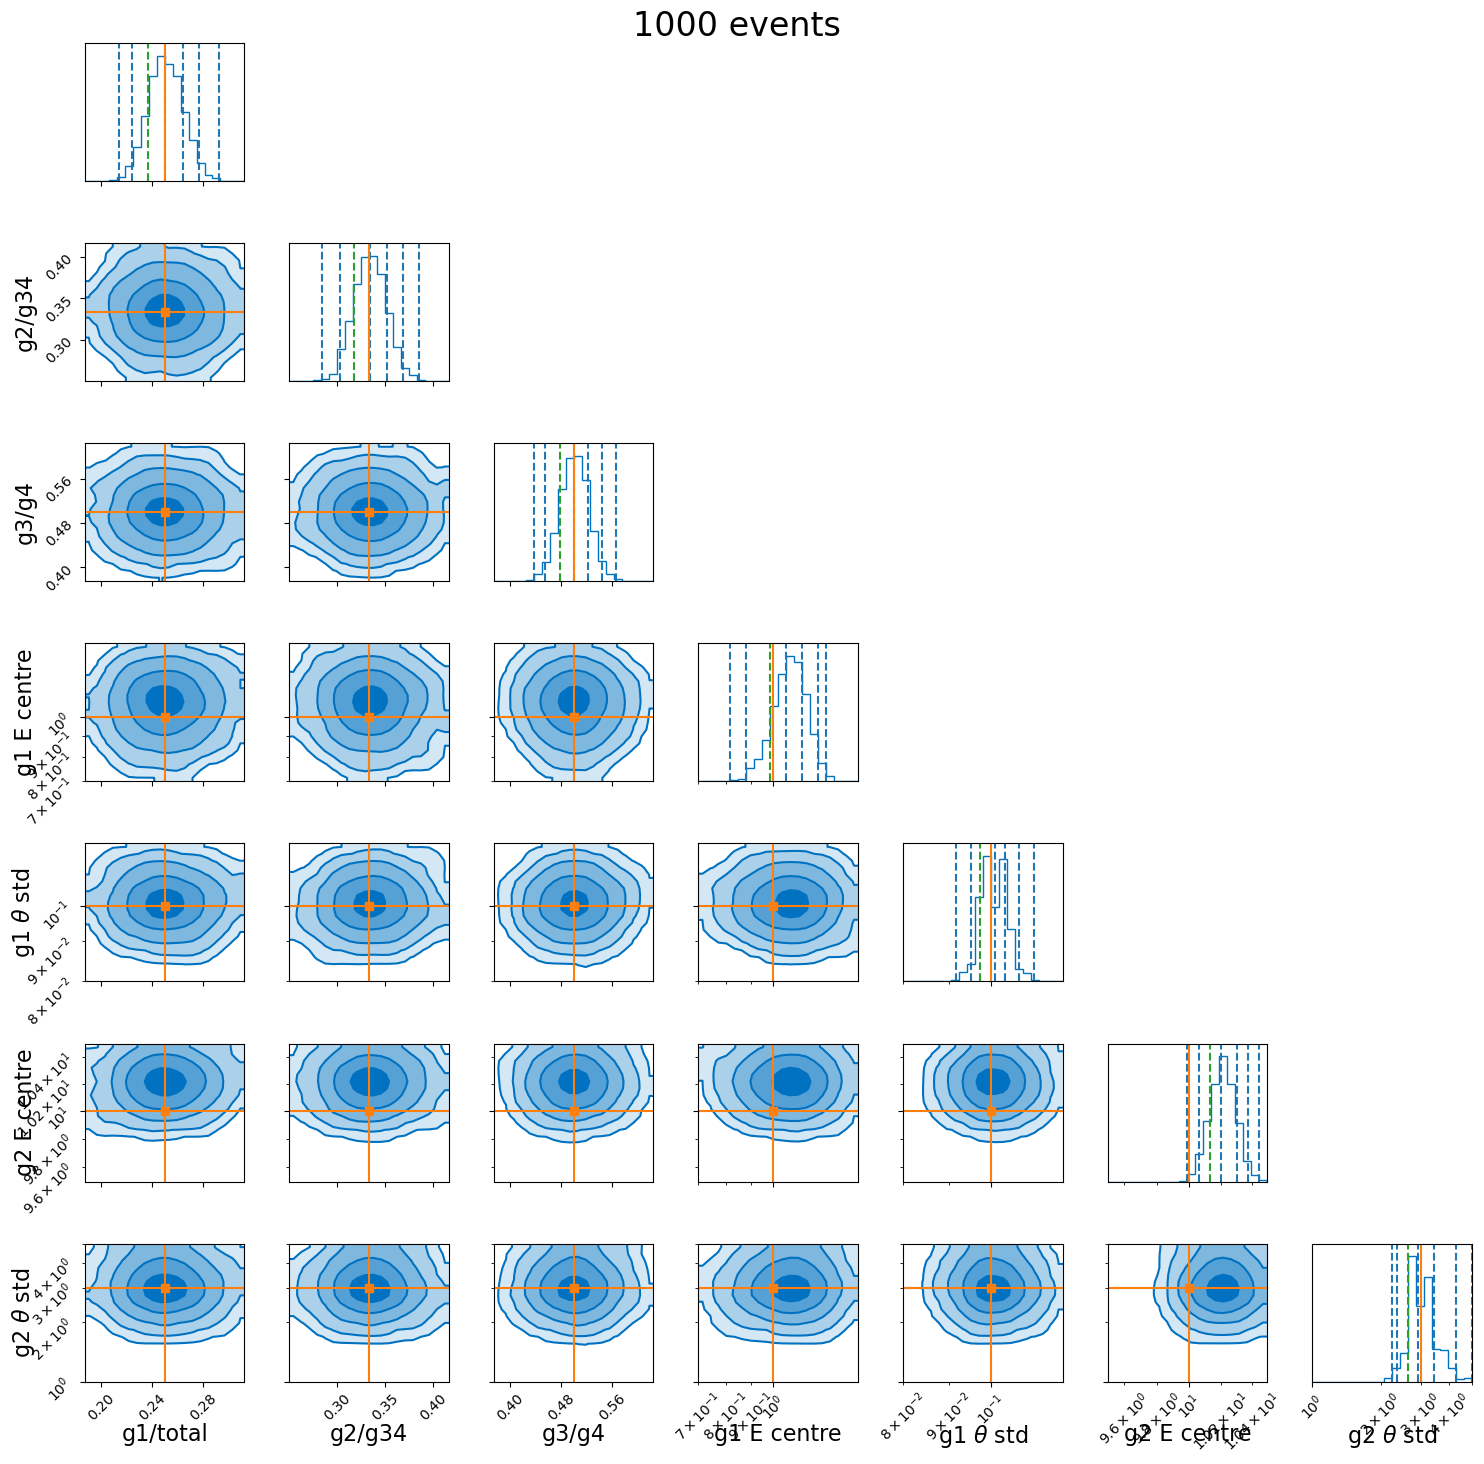

In [26]:
from corner import corner
from gammabayes.utils.plotting import defaults_kwargs
from scipy.special import logsumexp
defaults_kwargs['smooth'] = 1

axes_bounds_list_list = [[[axis.min(), axis.max()] for axis in parameter_set.axes] for parameter_set in parameter_sets]
mixture_axes_bounds_list = [mixture_parameter.bounds for mixture_parameter in mixture_parameter_set.values()]
axes_bounds_list = [*axes_bounds_list_list[0], *axes_bounds_list_list[1]]
num_params = 7
sampling_results = discrete_scan_hyperparameter_likelihood_instance.posterior_exploration_results
weights = np.exp(sampling_results.logwt - logsumexp(sampling_results.logwt))  # Calculate normalized weights
0.0015
fig = plt.figure(figsize=(15,15))
figure=corner(sampling_results.samples_equal(), fig=fig,
       quantiles=[0.0015, 0.025, .16, 0.5, .84, 0.975, 0.9985],
       axes_scale=['linear', 'linear', 'linear', 'log', 'log', 'log', 'log'],
       labels=['g1/total', 'g2/g34', 'g3/g4', 'g1 E centre', r'g1 $\theta$ std', 'g2 E centre', r'g2 $\theta$ std',],
       truths=[0.25,1/3, 0.5, 1.0, 0.1, 10.0, 3.0],
    #    bins=64,
       range=[[3/16,5/16], [3/12, 5/12], [3/8, 5/8], [7e-1, 1.5e0], [8e-2, 1.2e-1], [9.5e0, 1.05e1], [1e0,5e0]],
    
       **defaults_kwargs)

for ax_idx, ax in enumerate(figure.get_axes()):
    # Find lines representing the quantiles (the 3rd line for each histogram is the median, based on the ordering in `quantiles`)
    lines = ax.get_lines()
    if (len(lines) > 2):
        if (ax_idx%(num_params+1)==0): 
            for line_idx, line in enumerate(lines): # Check if there are enough lines (for histograms)
                if line_idx==2:
                    line.set_color('tab:green')  # Change the color of the median lines
                elif line_idx<len(lines)-1:
                    line.set_color('tab:blue')
plt.suptitle(str(measured_event_data.Nevents) + " events", size=24)

plt.tight_layout()
plt.show()
